# Bootstrap sampling

In [1]:
import xarray as xr
import numpy as np
import sys
import random
from scipy import stats
import glob
from resampling import _resample_iterations_idx
from definitions import * # imports all functions from definitions.py

xr.set_options(keep_attrs = True, display_style = 'html')  # Attributes of DataArrays will be kept through operations.

alt = [70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, \
       106, 108, 110, 112, 114, 116, 118, 120]
root_path = '/home/gemeinsam_tmp/UA_students/data/PW_GW_analysis/'
dir_path = '/home/hochatmstud/bene/'

In [2]:
def g_kde(y, x):
    """Firstly, kernel density estimation of the probability density function of randomized anomalies.
    Secondly, evaluates the estimated pdf on a set of points.
    
    Args:
        y (np.array): datapoints to estimate from (randomized anomalies)
        x (np.array): datapoints to be evaluated (composite values)
    Returns:
        np.array: the estimated pdf on composite values
    """
    print(y)
    mask = np.isnan(y)
    kde = stats.gaussian_kde(y[~mask])
    return kde(x)

In [3]:
station = 'Leipzig'

In [4]:
# Parameters
station = "Esrange"


## Wind measurements

In [5]:
ds_wind = read_group('wind',station)

u = read_var(ds_wind,'u0')
v = read_var(ds_wind,'v0')

u_anomalie = anomalie('dayofyear',u)

v_anomalie = anomalie('dayofyear',v)

sea_u = sea(40,station,u)
sea_u_anomalie = sea(40,station,u_anomalie)

sea_v = sea(40,station,v)
sea_v_anomalie = sea(40,station,v_anomalie)

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [6]:
#var = sys.argv[1] # ta, ua ; input variable
time_scale = sys.argv[2] # 20 or 30 ; input timescale
its = 10000 # 10000 ; number of samples
#what = sys.argv[4] # anomalies ; what kind of anomalies
#DJF_bool = sys.argv[5] # DJF only (bool)
rechunk = True # allows rechunking in xr.apply_ufunc

if station == 'Leipzig':
    size = 7
elif station == 'Esrange':
    size = 11
elif station == 'Sodankyla':
    size = 4
elif station == 'Sodankyla_Kiruna':
    size = 11
elif station == 'CMOR':
    size = 9
elif station == 'RioGrande':
    size = 4
elif station == 'Davis':
    size = 7

line_width = 5

In [7]:
#u_anomalie
u_anomalie['name'] = 'statistical significance'

### for-loop via the lags

In [8]:
u_anomalie = u_anomalie.sel(alt=slice(80,100)).dropna('time')

In [9]:
sea_u_anomalie = sea_u_anomalie.sel(alt=slice(80,100)).dropna('days')

In [10]:
p = []

for lag in range(-40,41,1):
    #print(comp_name, size)
    # samples generation (loaded from external function)
    rnd_arr = _resample_iterations_idx(u_anomalie, 
                                    its, 'time', replace=True, chunk=False, dim_max = size) 
    #print(rnd_arr)
    print("".ljust(line_width)+'{} samples generated'.format(its))
    ## load of composite dataarray
    #comp_file = f'{root_path}composites_woSSW{w_clim}/{var}_{what}_comp_{comp_name}_{time_scale}days.nc'
    #ds_comp = xr.open_dataarray(comp_file)*factor
    #print("".ljust(line_width)+'{} opened'.format(comp_file))
    
    # statistical significance calculation (vectorized g_kde)
    da_kde = xr.apply_ufunc(g_kde, rnd_arr, sea_u_anomalie.sel(days=lag),\
                       input_core_dims=[['iteration'], []],\
                       vectorize=True, dask='parallelized',\
                       exclude_dims=set(("iteration",)),  \
                       output_core_dims=[[]], \
                       output_dtypes=[sea_u_anomalie['u0_mean'].dtype])
    print("".ljust(line_width)+'p-values calculated')
    # output the calculation                        
    #outfile_name = f'{dir_path}bootstrap_test_{station}_lag_{lag}.nc'
    da_kde['name'] = u_anomalie['name']
    #da_kde.to_netcdf(outfile_name)
    #print("".ljust(line_width)+'{} saved'.format(outfile_name))
    #del da_kde, rnd_arr, ds_comp
    #print()
    #da_kde.plot.scatter(y='alt', x='u0_mean')
    #da_kde.plot.scatter(y='alt', x='u0_std')
    p.append(da_kde) 

     10000 samples generated
[-0.48062347  1.58962487  1.34934878 ...  3.89839506  2.30033325
  1.36402313]
[-0.01225449  0.10178903  1.0528958  ...  3.6010726   1.1180759
  1.84705477]
[ 0.65773147 -1.37634284  0.61680916 ...  3.84974105  1.12697986
  2.45332071]
[ 0.95306581 -2.71874963 -0.02120518 ...  3.57076801  0.78575086
  2.91947994]
[ 1.33060532 -3.8464743  -0.57252949 ...  3.15224803  0.50508574
  3.40884019]
[ 1.90658133 -4.53298741 -0.92402432 ...  2.66797828  1.15851037
  3.67850427]
[ 2.63316585 -4.5892246  -1.01505897 ...  2.48051292  1.1662304
  3.29734567]
[ 3.22068223 -4.53907568 -1.16711059 ...  2.26957721  0.89390363
  2.74465405]
[ 3.5364268  -4.48670807 -1.53970889 ...  2.38221576  0.73593019
  2.6167102 ]
[ 3.91401604 -3.64536115 -1.9933366  ...  2.92805204  0.8802864
  2.81519144]
[ 3.93597714 -1.08571341 -0.25063313 ...  6.03769298 -0.86056132
  6.30968712]
[-0.48062347  1.58962487  1.34934878 ...  3.89839506  2.30033325
  1.36402313]
[-0.01225449  0.10178903  

     10000 samples generated
[ 5.9888103   4.10047412 -1.28766449 ... -0.20698413 -1.5240783
  5.38203885]
[ 5.38006091  4.60066578 -0.63755515 ...  0.35469251 -0.71374744
  4.59708348]
[ 6.22785307  4.81919872  0.66563837 ...  1.13494797 -1.09579152
  3.20094306]
[ 5.3890128   4.45176159  2.13567179 ...  2.55059481 -1.49722363
  1.89595371]
[ 4.57076476  4.08344972  3.66679479 ...  3.90427804 -2.27242398
  0.50017742]
[ 3.34968448  3.75481332  4.80080548 ...  4.80125212 -2.60125145
 -0.44405643]
[ 3.12799163  3.50585855  5.53171624 ...  4.78113885 -2.92119066
 -1.1905347 ]
[ 2.56015792  2.88422612  5.84190007 ...  4.4229759  -2.99521728
 -1.7383337 ]
[ 1.79609694  1.94191117  5.79992313 ...  3.91930971 -3.01689962
 -1.68382463]
[ 0.62324895  0.80673336  5.83481918 ...  3.64783545 -3.21502833
 -0.70188449]
[-0.43577185  0.26272147  6.22939501 ...  3.30353838 -0.80852912
 -1.6398279 ]
[ 5.9888103   4.10047412 -1.28766449 ... -0.20698413 -1.5240783
  5.38203885]
[ 5.38006091  4.60066578 


[-0.082339    1.05703196  2.29807416 ... -4.1402476   6.97293561
  3.2964134 ]
[-0.30238783  1.55421122  1.66126857 ... -3.91696343  5.686085
  3.08045752]
[-0.6356421   1.53124034  1.21656243 ... -3.77351796  4.34446435
  2.6113239 ]
[-0.95563558  1.5495922   1.28999454 ... -3.56858183  3.76510899
  1.96973318]
[-1.23085839  1.43678122  1.32551233 ... -3.52320371  3.44961746
  1.5684648 ]
[-1.30058187  1.28413118  1.44052436 ... -3.02356093  2.89560825
  1.19798351]
[-1.14699877  0.76435354  1.30101686 ... -2.89393628  2.2648141
  1.16724859]
[-7.56405335e-01 -2.35237883e-03  1.16586720e+00 ... -3.19028628e+00
  1.91099532e+00  6.98934752e-01]
[-0.4272153  -0.86263328  1.84623024 ... -3.79925462  1.20628197
  0.31621138]
[ 1.99211191  0.46705357  3.19780158 ... -3.56819214  1.28701997
  1.20102183]
[-0.50026703  0.27205065  2.30947939 ... -4.06064886  7.87978741
  3.63041983]
[-0.082339    1.05703196  2.29807416 ... -4.1402476   6.97293561
  3.2964134 ]
[-0.30238783  1.55421122  1.66

     10000 samples generated
[-4.70001903  1.2638175   1.05049395 ...  0.38226505  4.01526714
 -1.97945112]
[-2.86786765  0.60215204  2.24263614 ... -0.35432641  4.16301645
 -3.47645878]
[-1.15760157 -0.16503138  2.36559439 ... -0.71782848  3.83992365
 -5.14309358]
[-0.11506833 -0.52105968  2.56462995 ...  0.07408728  2.69058259
 -6.84298685]
[ 0.11458593 -0.59515133  2.52926416 ...  0.97414441  1.08030128
 -7.536042  ]
[-0.20393215 -0.60591429  1.86909237 ...  2.10844944 -0.87243015
 -7.70955192]
[-0.28092803 -0.10117666  1.13355618 ...  2.84173007 -2.61866945
 -7.27155091]
[-0.04212604  0.42497846  1.2070375  ...  2.95276713 -3.64002016
 -6.88791544]
[-0.25348838  0.45012236  0.62598106 ...  3.1936624  -4.76390723
 -5.89402752]
[ 0.13010064 -0.30238933 -0.13069377 ...  3.39886505 -6.67614646
 -3.95212669]
[ 4.02305526  1.02963112  2.04047774 ...  3.99390525 -4.72783167
 -2.06354342]
[-4.70001903  1.2638175   1.05049395 ...  0.38226505  4.01526714
 -1.97945112]
[-2.86786765  0.6021520

     10000 samples generated
[ 3.17806327 -0.27499782 -0.26825002 ...  2.00084585 -2.67331317
  4.98808649]
[ 3.26808851  0.53386732 -0.12779116 ...  2.16558946 -1.74993616
  4.13062511]
[ 2.89475932  1.49412573  0.06058356 ...  1.72877284 -0.37456194
  2.94976433]
[2.53412151 1.65391718 1.01036615 ... 1.26599566 0.74213815 2.09845778]
[2.53943669 2.2467772  1.47411941 ... 0.95763246 1.65234871 1.35214851]
[2.89322411 2.62007587 2.20660216 ... 0.49216277 2.35076716 0.76868438]
[3.13573539 2.65752189 2.37219858 ... 0.31568583 3.26383556 0.09023047]
[ 3.22622333  2.61057556  2.43104216 ...  0.57545722  4.28236341
 -1.1114987 ]
[ 3.46620517  2.26952905  1.77094163 ...  1.24546814  4.49255559
 -1.43438102]
[ 3.62983783  2.0156111   1.65509176 ...  2.00422148  4.45933924
 -0.80873763]
[ 3.10221956  2.23108142 -1.1415544  ...  3.08907175  5.41030798
 -2.14729353]
[ 3.17806327 -0.27499782 -0.26825002 ...  2.00084585 -2.67331317
  4.98808649]
[ 3.26808851  0.53386732 -0.12779116 ...  2.1655894

     10000 samples generated
[-0.72780176  4.63832531  7.1527614  ...  2.96593592  1.57341234
  7.14338612]
[-1.51974568  4.48437652  6.16446981 ...  0.91134535  1.59829731
  5.37216612]
[-2.20779716  4.00221743  4.77541466 ...  0.34360851  0.50202771
  3.67506168]
[-2.84814263  3.40695882  3.19460829 ... -0.46470273 -0.2032497
  2.41903155]
[-3.35746851  2.89155325  1.69680091 ... -0.99103683 -0.78071474
  1.19882174]
[-4.22746055  1.95798697  0.41304378 ... -1.53960845 -1.38819397
 -0.20640633]
[-3.85972485  1.18568583 -0.93014505 ... -2.02294138 -1.61344594
 -1.61205183]
[-2.95671226  0.91984013 -1.72748741 ... -2.81874048 -1.81938983
 -2.96858633]
[-2.62323585  0.71013607 -2.2421953  ... -3.69642505 -1.99828872
 -4.44156472]
[-2.32001157  0.37541778 -2.49984548 ... -4.85277707 -2.4878682
 -5.88249089]
[-1.73460102  2.05931357  1.90136698 ... -7.23550178 -2.32992434
 -5.57774655]
[-0.72780176  4.63832531  7.1527614  ...  2.96593592  1.57341234
  7.14338612]
[-1.51974568  4.48437652 

     10000 samples generated
[ 5.43849317 -3.84795148 -4.55603277 ... -1.64935535 -0.72554914
  7.36410127]
[ 4.47956588 -4.56928337 -4.73864853 ... -0.92611506 -0.44789866
  5.5272245 ]
[ 4.63269868 -5.62879855 -5.26948634 ... -0.9351964  -1.22988165
  3.99054412]
[ 4.74218743 -6.34456609 -5.01439634 ... -1.51165157 -1.77595161
  2.92764184]
[ 4.24234225 -6.69742388 -4.2263781  ... -1.75802105 -2.01194407
  2.49911857]
[ 3.65191113 -7.46212528 -3.02496129 ... -2.36586479 -2.31638755
  1.92878727]
[ 3.19911067 -8.13093585 -2.06323925 ... -2.47245581 -2.72877555
  1.41276123]
[ 2.43516982 -8.27772771 -1.71128999 ... -2.35413728 -2.83527893
  0.56686794]
[ 1.78882646 -7.91216908 -2.29679029 ... -2.16109541 -2.94369296
 -0.69361518]
[ 0.59946944 -7.3213151  -3.0554058  ... -1.90538293 -3.29858879
 -1.26608823]
[ 2.04970074 -6.95747273 -2.79474959 ...  0.86280089 -1.57798723
 -4.40880276]
[ 5.43849317 -3.84795148 -4.55603277 ... -1.64935535 -0.72554914
  7.36410127]
[ 4.47956588 -4.5692833

     10000 samples generated
[ 0.56884033 -0.24674874  6.35071357 ... -2.0311904   7.4274619
 -6.97509332]
[-0.63819911 -0.16463763  6.00298002 ... -1.92498545  7.13103402
 -7.81245536]
[-0.74119507 -0.11660597  4.68444823 ... -1.86791718  6.77626466
 -8.10720169]
[-0.84716911 -0.62437004  3.38595856 ... -1.67997051  6.16597657
 -8.07158731]
[-0.77554152 -0.896       2.0624792  ... -1.7781126   5.29906997
 -8.16587329]
[-1.34150994 -0.88506521  0.63157026 ... -2.28839589  4.54520262
 -7.96562288]
[-2.27734421 -0.61643885 -0.65615204 ... -2.6474456   3.69284138
 -6.75960595]
[-2.83012165 -0.85864475 -1.83903212 ... -2.8915396   2.6800477
 -5.9018096 ]
[-2.74304122 -1.15669093 -2.7687907  ... -2.7912394   2.11679123
 -4.87783545]
[-2.63812651 -1.08613709 -2.96980689 ... -2.76034693  1.67492191
 -3.94998555]
[-2.71311751 -0.22360412 -2.85166021 ... -1.19329115  2.56009437
 -2.20649436]
[ 0.56884033 -0.24674874  6.35071357 ... -2.0311904   7.4274619
 -6.97509332]
[-0.63819911 -0.16463763  

     10000 samples generated
[-2.39522516 -2.12682426 -2.87110554 ...  2.94651493  0.8503366
 -3.57232589]
[-0.35087311 -0.79431425 -3.10096465 ...  2.54369359  1.49923229
 -4.1972012 ]
[ 1.43178238 -0.03211139 -3.24127588 ...  2.22815931  2.03171019
 -4.15325078]
[ 2.59715382  0.82900073 -3.27546338 ...  1.70105879  2.59507862
 -3.59338503]
[ 3.45220273  1.88477059 -3.38087184 ...  1.20103951  2.82973626
 -2.99755645]
[ 4.3254941   2.98668126 -3.30293687 ...  0.73289427  3.02098169
 -2.69858281]
[ 4.7552943   3.90969356 -2.94025505 ... -0.49600408  3.02457605
 -2.5057292 ]
[ 4.49072222  4.55645712 -2.06841162 ... -1.61676251  3.08824242
 -2.34199072]
[ 4.33273128  4.44163302 -1.11580177 ... -2.11791722  2.86445629
 -2.36313213]
[ 4.70355025  3.88524845  0.0290042  ... -1.54195399  2.5197178
 -1.58375795]
[ 6.51327138  3.76442583  1.93586765 ... -1.0756785   2.05130417
 -2.75546319]
[-2.39522516 -2.12682426 -2.87110554 ...  2.94651493  0.8503366
 -3.57232589]
[-0.35087311 -0.79431425 -

     10000 samples generated
[ 2.39916271 -3.5679348   4.78369562 ... -3.56325642  1.23122319
  0.18009215]
[ 3.52981129 -2.66668222  2.67206822 ... -1.62952551  1.67700108
  1.48318564]
[ 3.31911119 -1.86293034  0.43240152 ... -0.0655098   1.85140987
  2.27009966]
[ 2.79774526 -1.42454116 -1.50876705 ...  0.91373496  1.82335636
  2.40196681]
[ 2.5070358  -1.30594274 -2.45744508 ...  1.36990571  1.56735833
  2.9131202 ]
[ 2.49308735 -1.19023889 -3.40838763 ...  1.85236865  1.29314914
  2.73493034]
[ 2.70494898 -0.90000083 -4.08681581 ...  2.00505084  1.19895462
  2.11246515]
[ 2.68429747 -0.07201599 -4.41862686 ...  2.12075776  1.07203896
  1.42389634]
[ 2.48950706 -0.16312179 -5.07959135 ...  1.84069062  1.08897077
  0.79315707]
[ 2.12497877 -0.46726444 -5.25176207 ...  1.40549164  1.06811713
  0.76006692]
[ 1.14621208  0.65182306 -5.31968004 ... -1.01713221  2.68453766
  1.52336932]
[ 2.39916271 -3.5679348   4.78369562 ... -3.56325642  1.23122319
  0.18009215]
[ 3.52981129 -2.6666822

     10000 samples generated
[-1.46915007 -0.34906723  1.10440051 ...  1.95920248 -3.34341253
 -0.63280364]
[-0.68141312  0.3859593   1.83006165 ...  1.54236787 -0.92845187
  0.35615501]
[-0.89188719  0.47824817  2.35990289 ...  1.55680617 -0.5289564
  1.21887556]
[-1.168504    0.33018811  2.25593954 ...  1.2096326   0.00975642
  1.77373752]
[-1.69646498  0.33152383  2.49715241 ...  0.91289062  0.21147263
  2.07669545]
[-1.51047643 -0.03649107  2.89999721 ...  0.66734349  0.60340293
  2.22247274]
[-1.68950939  0.05078616  3.38262923 ...  0.66493568  0.7363301
  1.74747334]
[-1.88524368  0.61064669  3.15620729 ...  0.64416886  0.81385491
  0.81802781]
[-2.20872674  1.17471042  2.58373422 ...  0.78358638  0.95026556
 -0.45236401]
[-2.3342185   1.81318444  1.90797348 ...  1.02351148  1.4329624
 -0.61628064]
[-0.97057681  3.39114296  3.80691608 ...  1.14074614  8.5570376
 -0.61951165]
[-1.46915007 -0.34906723  1.10440051 ...  1.95920248 -3.34341253
 -0.63280364]
[-0.68141312  0.3859593   1

[-0.21836642  1.94646739  0.8513174  ...  1.77824144  2.3138835
  1.19228546]
[-1.37951853  0.78603171 -0.5768328  ...  1.53636931  1.68033905
  0.5251387 ]
[-1.89775464 -0.13810146 -1.87840244 ...  1.08354466  1.4298721
 -0.27621431]
[-1.91770677 -0.58330284 -2.95497188 ...  0.40332281  1.36513035
 -1.1076032 ]
[-1.75006217 -1.10438629 -2.93797422 ... -0.14120996  1.37076749
 -1.55572731]
[-1.23877958 -1.2735511  -2.88234108 ... -0.9067608   2.06188811
 -1.52526003]
[ 2.74485013  0.16248296 -1.68100098 ... -0.81866884  4.3821981
 -1.05941112]
[1.30846857 2.98989351 3.33552335 ... 0.86138755 2.90038307 1.37428955]
[1.82955886 3.73992565 3.48396495 ... 1.60387464 2.35409767 1.63264078]
[1.29481918 3.52716202 3.17105909 ... 1.52706062 2.47743509 1.40155842]
[0.5953571  2.98356194 2.34520704 ... 1.71309258 2.55968854 1.26950486]
[-0.21836642  1.94646739  0.8513174  ...  1.77824144  2.3138835
  1.19228546]
[-1.37951853  0.78603171 -0.5768328  ...  1.53636931  1.68033905
  0.5251387 ]
[-1.8

[-4.2977719   2.75572788 -0.74505734 ... -2.29537964 -2.88063889
  2.65614728]
[-4.22022641  1.77035633 -1.08235531 ... -2.30835706 -2.50663826
  2.47690056]
[-4.51824159  0.71041617 -1.35229072 ... -2.08997259 -2.26513573
  1.96858976]
[-4.42738577 -0.60349204 -2.32966027 ... -1.78051805 -1.50039331
  1.19507737]
[-3.97627547 -1.96975957 -3.30029933 ... -1.74245882 -0.21934091
  0.46229308]
[-2.41708273 -2.64548144 -4.81434802 ... -1.68128283  0.96253535
  0.12014217]
[-1.88101197 -4.08189634 -2.61949979 ... -0.61464329  2.98651218
  5.13991904]
     p-values calculated
     10000 samples generated
[ 2.25911896 -1.19986428  0.86630345 ... -2.90086056  3.52893958
  4.96714607]
[ 1.47799815 -1.33237045  2.29792644 ... -1.99706269  2.42139238
  3.81854315]
[ 0.74460495 -1.39930901  2.48762835 ... -1.64275616  1.48104438
  1.7965046 ]
[-0.3726265  -2.2193437   2.16681994 ... -0.70959117  0.41134938
  0.01552016]
[-1.60669633 -2.81835255  1.63836194 ... -0.11790523 -0.38850145
 -1.48355622

[-1.24883096 -4.01847681  0.32382843 ... -1.66062732  0.53216812
  0.22254924]
[-1.46948028 -4.64255592  0.06353821 ... -1.53315235  1.22975366
  0.78592458]
[-1.63087567 -4.98145664 -0.37635639 ... -1.33406405  1.59128147
  0.61302859]
[-2.29475434 -4.94568321 -0.64951225 ... -1.63696784  1.0934676
  0.25687277]
[-3.50725936 -4.9041262  -0.92224309 ... -1.805903    0.71053022
 -0.39159648]
[-3.94022919 -3.1280009  -2.33181205 ... -3.9634802  -0.72217296
  0.92830336]
     p-values calculated
     10000 samples generated
[ 4.29281871 -1.0143396   6.85049732 ...  2.11129698  3.14477159
  3.90621359]
[ 4.10756239 -0.46154545  6.46061791 ...  2.96786728  3.28363766
  4.19110394]
[ 3.33449049 -1.05298771  5.44215727 ...  3.13343646  2.71974042
  4.73177551]
[ 2.53710302 -1.07504211  3.92561163 ...  3.14682806  1.47047478
  4.5460329 ]
[ 0.97241756 -1.06534202  2.0035026  ...  3.23477236  0.45270722
  4.63266804]
[-0.98830771 -0.53685543  0.3241816  ...  3.13157323 -0.51730169
  4.5669248 ]

[ 1.2568209  -1.46265508 -7.14578966 ...  3.23845001 -5.74673648
 -3.56704727]
[ 1.4522262  -0.38375772 -7.17399116 ...  2.36280151 -5.18832405
 -4.26422048]
[ 0.43201916  0.32322649 -4.73618494 ...  3.03890389 -3.9788035
 -5.09130513]
     p-values calculated
     10000 samples generated
[2.49350777 6.91849508 0.85486111 ... 6.79861025 6.53342399 2.13674059]
[ 1.68336226  6.61007186 -0.58569708 ...  5.0498209   6.26604189
  1.33061999]
[ 0.46011608  5.69513477 -2.28541663 ...  3.65256245  4.89237975
  0.93223596]
[-1.36756345  3.86144467 -3.55292057 ...  2.6621374   3.30767944
  0.02279412]
[-2.85097847  1.76182672 -4.31000379 ...  1.49179328  1.57140033
 -0.85141711]
[-3.7149077  -0.13068954 -4.49270187 ...  0.39968874  0.20958021
 -1.7144502 ]
[-4.01064135 -1.75899617 -4.26644515 ... -0.29543024 -0.7106608
 -2.09719418]
[-4.0847536  -2.76969511 -3.69782182 ... -1.00771139 -1.6752406
 -2.03954545]
[-4.33182151 -3.07518613 -2.98407754 ... -1.12767806 -2.72693965
 -1.82680983]
[-6.1072

     10000 samples generated
[ 5.06266416  4.67879209 -0.17289279 ... -2.44621683  0.76549925
  1.21257238]
[ 4.48596078  4.74401902 -0.61723394 ... -2.71873493  1.59661958
  0.82372585]
[ 3.93475906  4.15993804 -0.73363517 ... -2.58385082  1.46164186
  0.38226426]
[ 3.42508831  3.01516401 -0.73207131 ... -2.43037733  1.2031204
 -0.11094814]
[ 3.17673808  2.07389499 -0.86773394 ... -2.46880578  0.75869478
 -0.58520474]
[ 2.44000824  1.20684687 -1.48783905 ... -2.60844856  0.49909897
 -1.18584378]
[ 1.06040077  0.28744596 -1.4421986  ... -2.84454474 -0.02105322
 -1.72417597]
[ 0.02930232 -0.49653083 -1.37463043 ... -2.70475625 -0.89407806
 -2.20965265]
[-0.90724183 -1.72964357 -1.27170962 ... -3.47994891 -1.94189019
 -2.18258136]
[-1.5701302  -2.65451785 -1.43443109 ... -3.80502316 -2.73397898
 -1.99583361]
[-0.58789088 -2.2926311  -0.74719659 ... -3.07458817 -0.09265144
 -2.50651536]
[ 5.06266416  4.67879209 -0.17289279 ... -2.44621683  0.76549925
  1.21257238]
[ 4.48596078  4.74401902

[-3.34181664 -0.91676411  5.4471951  ... -1.80636735  5.58738792
 -3.89888456]
     p-values calculated


In [11]:
p_comp =  xr.concat(p, dim = 'days')
p_comp['days'] = range(-40, 40+1)
p_comp = p_comp.where(p_comp['u0_mean'] < 0.05, other = -0.05)

In [12]:
#p_comp

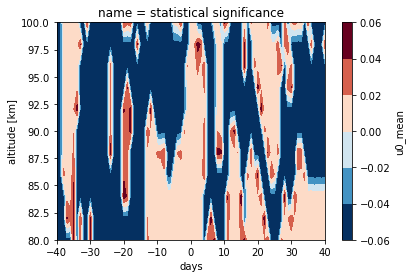

In [13]:
p_comp['u0_mean'].plot.contourf(x='days')